In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from os.path import expanduser
from tqdm import tqdm
from aesthetics import plotting
import csv
import operator

import scipy.stats as ss
from scipy.stats import sem, pearsonr, zscore

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'timezone', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [2]:
data_path = expanduser('~/data/katie/')
control_name = '041117_Controls_Revised.csv'
experimental_name = '041117_Revised_Norm_Exp_Sans_D3.csv'

In [3]:
controlfile = open(data_path + control_name, 'r')
control_reader = csv.reader(controlfile)

In [4]:
control_list = collections.defaultdict(list)
labels = []
for idl,line in enumerate(control_reader):
    if idl == 0:
        for l in line:
            labels.append(l)
    else:
        if line[0] != '':
#             print(line[0])
            for idi,l in enumerate(line):
                if l == '':
                    control_list[labels[idi]].append(np.nan)
                elif idi > 0:
                    control_list[labels[idi]].append(float(l))
                elif idi == 0:
                    control_list[labels[idi]].append(l)

In [5]:
for m in control_list['Mouse']:
    # mouse id x day
    this_split = m.split('.')
    control_list['mouse_id'] = this_split[0]

In [6]:
variables = [k for k in control_list.keys() if k not in ['mouse_id', 'Mouse', 'DPI', 'Infected (1/0)',
                                                        'Parasitemia', 'Parasite Density', 'Accuri', 'Cells',
                                                        'palmitoyl-arachidonoyl-glycerol (16:0/20:4) [2]*',
                                                        'palmitoyl-linoleoyl-glycerol (16:0/18:2) [1]*',
                                                        'Direct Bilirubin', 
                                                         'lactosyl-N-palmitoyl-sphingosine (d18:1/16:0)',
                                                         'cerotoylcarnitine (C26)*', 'GGT']]

In [7]:
variables

['ribitol',
 'pyridoxate',
 '2-hydroxyoctanoate',
 '5-methylcytidine',
 '2-stearoyl-GPE (18:0)*',
 'Erythrocyte-C',
 '1-linoleoyl-2-linolenoyl-GPC (18:2/18:3)*',
 'heme',
 'hexanoylcarnitine (C6)',
 'sphingomyelin (d18:2/24:1, d18:1/24:2)*',
 'laurylcarnitine (C12)',
 'hexadecanedioate',
 'methylmalonate (MMA)',
 '3-hydroxybutyrylcarnitine (2)',
 'arachidate (20:0)',
 '2-aminoadipate',
 '1-linoleoyl-GPE (18:2)*',
 '4-hydroxycinnamate',
 '1-palmitoleoyl-GPC (16:1)*',
 '1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*',
 'N6-acetyllysine',
 'stearoyl ethanolamide',
 'gamma-glutamyltyrosine',
 '1-stearoyl-2-oleoyl-GPC (18:0/18:1)',
 'N-acetyltryptophan',
 'Platelets',
 'adenine',
 'N-palmitoyl-sphinganine (d18:0/16:0)',
 'myristoleate (14:1n5)',
 'phosphate',
 'MCP-1',
 'uridine',
 'o-cresol sulfate',
 'sphingomyelin (d18:2/24:2)*',
 '3-hydroxybutyrylcarnitine (1)',
 'orotidine',
 'palmitoyl ethanolamide',
 'valine',
 'imidazole propionate',
 'indolepropionate',
 'uracil',
 '3-methoxytyro

In [8]:
time = control_list['DPI']

# Load experimental data

In [9]:
experimental_file = open(data_path + experimental_name, 'r')
experimental_reader = csv.reader(experimental_file)

experimental_list = collections.defaultdict(list)
labels = []
for idl,line in enumerate(experimental_reader):
    if idl == 0:
        for l in line:
            labels.append(l)
    else:
        if line[0] != '':
#             print(line[0])
            for idi,l in enumerate(line):
                if l == '':
                    experimental_list[labels[idi]].append(np.nan)
                elif idi > 0:
                    experimental_list[labels[idi]].append(float(l))
                elif idi == 0:
                    experimental_list[labels[idi]].append(l)

In [10]:
for m in experimental_list['Mouse']:
    # mouse id x day
    this_split = m.split('.')
    experimental_list['mouse_id'] = this_split[0]

In [11]:
time_experimental = experimental_list['DPI']

#### Average data points that fall on the same day

In [12]:
average_experimental_time = sorted(np.unique(time_experimental))

In [13]:
averaged_experimental_data = collections.defaultdict(list)
for v in variables:
    averaged_vals = []
    these_vals = experimental_list[v]
    for t in average_experimental_time:
        averaged_vals.append(np.nanmean([val for i,val in enumerate(these_vals) if time_experimental[i] == t]))
    averaged_experimental_data[v] = np.array(averaged_vals)

In [14]:
len(averaged_experimental_data.keys())

635

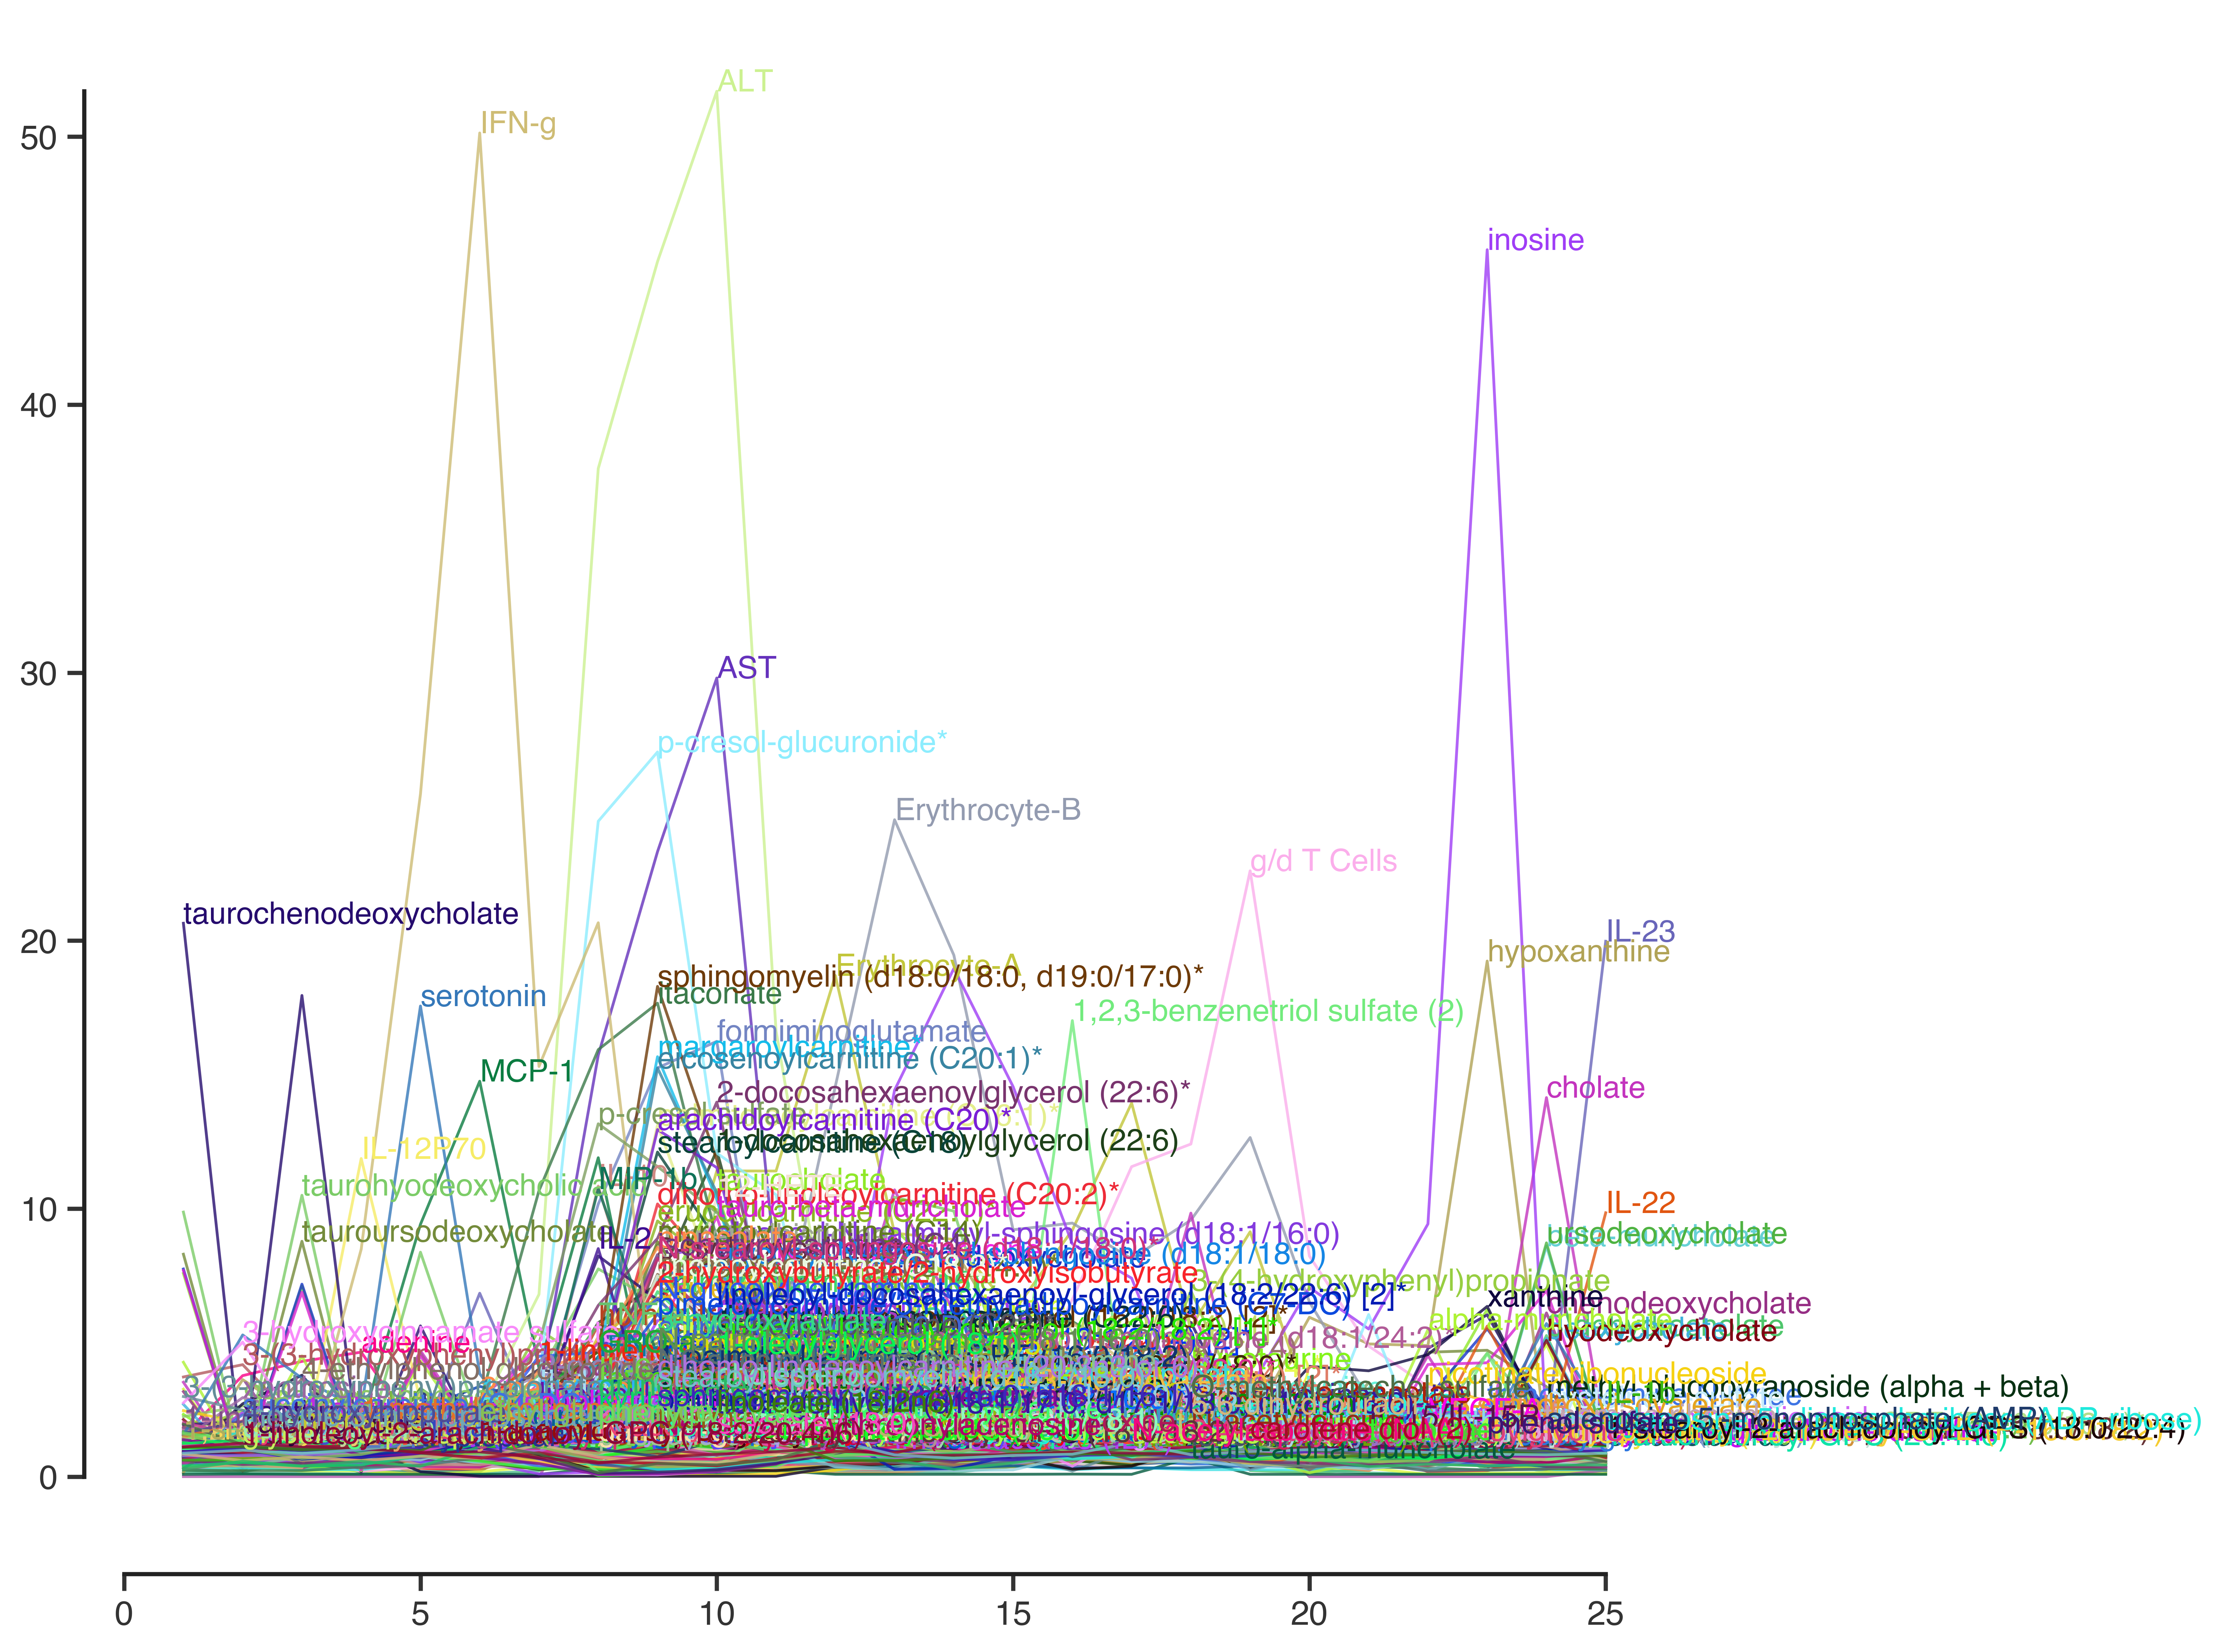

In [15]:
fig = plt.gcf()
fig.set_size_inches((10,10))

for var in averaged_experimental_data.keys():
    random_color = np.random.rand(3)
    plt.plot(average_experimental_time, averaged_experimental_data[var], linewidth=1, alpha=0.8,
             color=random_color)
    plt.text(average_experimental_time[np.argmax(averaged_experimental_data[var])],
             np.max(averaged_experimental_data[var]),
             '%s' %var, color=random_color, fontsize=11)
    
plotting.adjust_spines(plt.gca())

# Log likelihood analysis with Gamma distribution

In [23]:
gamma_sum_neg_ll = collections.defaultdict(list)
gamma_sum_neg_ll_avg = collections.defaultdict(list)
for v in tqdm(variables):
    these_control_vals = np.array(control_list[v])
    these_control_vals = these_control_vals[~np.isnan(these_control_vals)]
    these_control_vals -= np.nanmin(these_control_vals)
    if np.min(these_control_vals) < 0:
        print('Control %s has minimum of %0.2f' %(v, np.min(these_control_vals)))
        
    this_gamma = ss.gamma.fit(these_control_vals)
    
    if np.min(experimental_list[v]) < 0:
        print('Experimental %s has minimum of %0.2f' %(v, np.min(experimental_list[v])))
    
    if np.any(np.isnan(experimental_list[v])):
        print('Variable %s has %d nans' %(v, sum(np.isnan(experimental_list[v]))))
        
    these_exp_vals = np.array(experimental_list[v])
    these_exp_vals = these_exp_vals[~np.isnan(these_exp_vals)]
    these_exp_vals -= np.nanmin(these_exp_vals)
    
    neg_logpdf = -ss.gamma.logpdf(these_exp_vals, *this_gamma)
    neg_logpdf_avg = -ss.gamma.logpdf(averaged_experimental_data[v] - np.nanmin(averaged_experimental_data[v]),
                                      *this_gamma)
    gamma_sum_neg_ll[v] = np.sum(neg_logpdf)
    gamma_sum_neg_ll_avg[v] = np.sum(neg_logpdf_avg)
    
least_likely_data = sorted(gamma_sum_neg_ll.items(), key=operator.itemgetter(1), reverse=True)
least_likely_data_avg = sorted(gamma_sum_neg_ll_avg.items(), key=operator.itemgetter(1), reverse=True)

  6%|▌         | 36/635 [00:01<00:22, 26.98it/s]

Variable MCP-1 has 1 nans


  9%|▉         | 60/635 [00:02<00:20, 28.67it/s]

Variable IL-18 has 1 nans


 13%|█▎        | 81/635 [00:03<00:23, 23.71it/s]

Variable IL-31 has 1 nans
Variable IL-23 has 1 nans


 19%|█▊        | 119/635 [00:04<00:18, 27.79it/s]

Variable IL-12P70 has 1 nans


 27%|██▋       | 172/635 [00:06<00:18, 24.84it/s]

Variable TGF-b has 1 nans


 30%|███       | 192/635 [00:07<00:16, 26.36it/s]

Variable IL-10 has 1 nans


 36%|███▋      | 231/635 [00:08<00:16, 24.92it/s]

Variable RANTES has 1 nans
Variable GM-CSF has 1 nans


 37%|███▋      | 237/635 [00:09<00:16, 24.48it/s]

Variable IFN-a has 1 nans
Variable IL-17A has 1 nans
Variable IL-9 has 1 nans


 42%|████▏     | 268/635 [00:10<00:13, 26.86it/s]

Variable M-CSF has 1 nans


 43%|████▎     | 276/635 [00:10<00:13, 27.15it/s]

Variable G-SCF/CSF-3 has 1 nans


 46%|████▋     | 294/635 [00:11<00:12, 26.84it/s]

Variable IL-3 has 1 nans
Variable IL-6 has 1 nans


 47%|████▋     | 301/635 [00:11<00:12, 25.86it/s]

Variable IL-28 has 1 nans


 48%|████▊     | 307/635 [00:11<00:14, 23.32it/s]

Variable LIX has 1 nans
Variable EOTAXIN has 1 nans


 51%|█████     | 322/635 [00:12<00:14, 21.74it/s]

Variable MIP-2 has 1 nans


 52%|█████▏    | 333/635 [00:13<00:14, 21.44it/s]

Variable IL-4 has 1 nans


 55%|█████▍    | 348/635 [00:13<00:12, 22.20it/s]

Variable TNF-a has 1 nans
Variable MIP-1a has 1 nans


 57%|█████▋    | 363/635 [00:14<00:11, 22.71it/s]

Variable IP-10 has 1 nans


 59%|█████▉    | 374/635 [00:14<00:10, 23.79it/s]

Variable MCP-3 has 1 nans


 64%|██████▍   | 405/635 [00:16<00:09, 25.23it/s]

Variable VEGF-A has 1 nans
Variable IL-27 has 1 nans


 65%|██████▌   | 414/635 [00:16<00:08, 26.71it/s]

Variable IL-5 has 1 nans


 68%|██████▊   | 431/635 [00:17<00:08, 23.35it/s]

Variable IL-22 has 1 nans


 73%|███████▎  | 462/635 [00:18<00:06, 26.12it/s]

Variable GRO-a has 1 nans
Variable LIF has 1 nans


 74%|███████▎  | 468/635 [00:18<00:07, 22.63it/s]

Variable MIP-1b has 1 nans


 83%|████████▎ | 526/635 [00:20<00:04, 24.49it/s]

Variable IFN-g has 1 nans


 88%|████████▊ | 559/635 [00:22<00:02, 29.26it/s]

Variable IL-2 has 1 nans


 92%|█████████▏| 586/635 [00:23<00:01, 26.65it/s]

Variable IL-15/IL-15R has 1 nans
Variable IL-13 has 1 nans


 98%|█████████▊| 622/635 [00:24<00:00, 22.46it/s]

Variable IL-1b has 1 nans


 99%|█████████▉| 629/635 [00:24<00:00, 24.62it/s]

Variable IL-1a has 1 nans


100%|██████████| 635/635 [00:24<00:00, 25.43it/s]


In [24]:
infinitely_unlikely = []
for variable_name, neg_ll in least_likely_data:
    if ~np.isfinite(gamma_sum_neg_ll[variable_name]):
        print(variable_name)
        infinitely_unlikely.append(variable_name)

In [25]:
len(infinitely_unlikely)

0

In [26]:
for i in range(10):
    print(least_likely_data[i])

('IL-12P70', 9121.2329785309757)
('itaconate', 8963.7746096284136)
('Erythrocyte-B', 8861.9273504979628)
('eicosenoylcarnitine (C20:1)*', 6467.5121820344984)
('IL-3', 5377.9576539205882)
('ALT', 4003.0423927275206)
('glycosyl-N-palmitoyl-sphingosine (d18:1/16:0)', 3382.5359619719684)
('orotate', 3220.8687178439204)
('g/d T Cells', 2853.89530633088)
('1-linoleoylglycerol (18:2)', 2732.9638551791527)


In [27]:
for i in range(10):
    print(least_likely_data_avg[i])

('itaconate', 1746.0666271246826)
('Erythrocyte-B', 1701.6760268808041)
('IL-12P70', 1486.6633555693654)
('eicosenoylcarnitine (C20:1)*', 1124.8851393656091)
('ALT', 740.44476907358546)
('glycosyl-N-palmitoyl-sphingosine (d18:1/16:0)', 609.15672920335965)
('orotate', 600.33965802764283)
('IL-3', 566.57663872275168)
('g/d T Cells', 543.23640976604941)
('IFN-g', 444.66176229062313)


In [35]:
with open('2017-04-11_Ranked_least_likely_gamma_distribution_no_outlier.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in least_likely_data:
        this_writer.writerow([var_name, nllv])

In [36]:
with open('2017-04-11_Ranked_least_likely_gamma_distribution_avg_no_outlier.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in least_likely_data_avg:
        this_writer.writerow([var_name, nllv])

## With normal distribution

In [30]:
normal_sum_neg_ll = collections.defaultdict(list)
normal_sum_neg_ll_avg = collections.defaultdict(list)
for v in tqdm(variables):
    these_control_vals = np.array(control_list[v])
    these_control_vals = these_control_vals[~np.isnan(these_control_vals)]
    this_dist = ss.norm.fit(these_control_vals)
            
    these_exp_vals = np.array(experimental_list[v])
    these_exp_vals = these_exp_vals[~np.isnan(these_exp_vals)]

    neg_logpdf = -ss.norm.logpdf(these_exp_vals, *this_dist)
    neg_logpdf_avg = -ss.norm.logpdf(averaged_experimental_data[v] - np.nanmin(averaged_experimental_data[v]),
                                      *this_dist)
    normal_sum_neg_ll[v] = np.sum(neg_logpdf)
    normal_sum_neg_ll_avg[v] = np.sum(neg_logpdf_avg)
    
normal_least_likely_data = sorted(normal_sum_neg_ll.items(), key=operator.itemgetter(1), reverse=True)
normal_least_likely_data_avg = sorted(normal_sum_neg_ll_avg.items(), key=operator.itemgetter(1), reverse=True)

100%|██████████| 635/635 [00:00<00:00, 2193.41it/s]


In [31]:
for i in range(10):
    print(normal_least_likely_data[i])

('itaconate', 809871.40152320184)
('ALT', 214784.13662849012)
('IFN-g', 160027.5299014404)
('Erythrocyte-B', 114175.6419139277)
('AST', 59017.104285403693)
('orotate', 39208.173795720846)
('MCP-1', 32940.676718687864)
('methylsuccinate', 27869.556231359773)
('g/d T Cells', 26575.65505838937)
('IL-12P70', 23213.154906184576)


In [32]:
for i in range(10):
    print(normal_least_likely_data_avg[i])

('itaconate', 142769.88458250015)
('IFN-g', 26281.47756151397)
('ALT', 22212.283723440778)
('Erythrocyte-B', 19907.679609321109)
('AST', 6302.459612349764)
('orotate', 4940.9014220994331)
('g/d T Cells', 3955.4091392229207)
('MCP-1', 3932.6168836749475)
('methylsuccinate', 3575.2411506302237)
('IL-12P70', 3198.5754241562213)


In [33]:
with open('2017-04-11_Ranked_least_likely_normal_distribution_no_outlier.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in normal_least_likely_data:
        this_writer.writerow([var_name, nllv])
        
with open('2017-04-11_Ranked_least_likely_normal_distribution_avg_no_outlier.csv', 'w') as csvfile:
    this_writer = csv.writer(csvfile, delimiter=',')
    for var_name, nllv in normal_least_likely_data_avg:
        this_writer.writerow([var_name, nllv])